In [1]:
import pandas as pd
import numpy as np
import os, sys, inspect
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# add parent dir to system dir
currdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootdir = os.path.dirname(currdir)
sys.path.insert(0, rootdir)
mpl.style.use("seaborn")
from src.utils import get_temporal_data, get_spatial_data
from src.utils import create_difference_sequence
from src.utils import series_to_supervised

Using TensorFlow backend.


In [2]:
ffname_realestate = os.path.join(rootdir, "data", "int", "realestate_demographics.csv")
realestate_df = pd.read_csv(ffname_realestate)

ffname_zipcodes = os.path.join(rootdir, "data", "int", "zip_codes.csv")
zipcode_df = pd.read_csv(ffname_zipcodes)
# zipcode_df.insert(loc=0, column="78701", value=78701)
# zipcode_df = zipcode_df.rename(columns={"78701": "Zip Code"})
# zipcode_df.loc[40, "Zip Code"] = 78701
# zipcode_df.astype(int, inplace=True)
# zipcode_df.sort_values(by=["Zip Code"], inplace=True)
# zipcode_df.reset_index(inplace=True)
# zipcode_df.to_csv(ffname_zipcodes, columns=["Zip Code"], index=False
realestate_df.head()

,Zip Code,Year,Month,Home Value Index,Median Listing Price,Median Listing Price Per sqf,Sales,Median Income (dollars),Number of Households,School Rating (Parent),...,Liquor Store Count,Wal-Mart Count,Starbucks Count,Target Count,Inventory Measure,Median Price Cut,Median Price of Reduction,Median Rental Price,Latitude,Longitude
0,78701,1996,4,152500.0,NaN,NaN,NaN,NaN,NaN,2.8,...,61,1,29,7,NaN,NaN,NaN,NaN,30.272921,-97.744386
1,78701,1996,5,153600.0,NaN,NaN,NaN,NaN,NaN,2.8,...,61,1,29,7,NaN,NaN,NaN,NaN,30.272921,-97.744386
2,78701,1996,6,154600.0,NaN,NaN,NaN,NaN,NaN,2.8,...,61,1,29,7,NaN,NaN,NaN,NaN,30.272921,-97.744386
3,78701,1996,7,155500.0,NaN,NaN,NaN,NaN,NaN,2.8,...,61,1,29,7,NaN,NaN,NaN,NaN,30.272921,-97.744386
4,78701,1996,8,156300.0,NaN,NaN,NaN,NaN,NaN,2.8,...,61,1,29,7,NaN,NaN,NaN,NaN,30.272921,-97.744386


In [3]:
period = [2011, 2017]
# 
# set plot params
figsize = (15, 30)
titlefontsize = 20
xtickfontsize = 17
ytickfontsize = 17
legendfontsize = 19

columns = ["Median Listing Price Per sqf",
           "Median Price Cut",
           "Median Price of Reduction",
           "Inventory Measure",
           "Mortgage Rate_15",
           "Mortgage Rate_30",
           "Total_NewConstructions",
           "Total_RemodelsRepairs",]
zipcodes = [78703, 78704, 78717, 78726, 78731,
            78746, 78747, 78748, 78750, 78753]

In [90]:
# preprcess data: trim and fill
df = pd.DataFrame()
for i, zipcode in enumerate(zipcodes):
    print(f"ploting processed trends for {zipcode}...", end="")
    zipcode_df = get_temporal_data(zipcode, realestate_df)
    zipcode_df = zipcode_df[["Zip Code", "Year", "Month"] + columns] 
    zipcode_df = zipcode_df[(zipcode_df["Year"] >= period[0]).values &
                            (zipcode_df["Year"] < period[1]).values]
    # fill missing values with previous enteires
    zipcode_df.fillna(method='ffill', inplace=True)
    
    time_stamp = zipcode_df[["Year", "Month"]].astype(str).apply(lambda x: "-".join(x), axis=1)
    time_stamp = zipcode_df["Year"].astype(str)
    
    # get all zipcode values
    df = df.append(zipcode_df, ignore_index=False)
#     data = np.concatenate(data, zipcode_df[columns].values)
    
    
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots(len(columns), 1)

    for i, column in enumerate(columns):

        if column in [
            "Home Value Index",
            "Median Listing Price Per sqf",
            "Median Listing Price",
            "Median Price Cut",
            "Median Price of Reduction",
            "Median Rental Price",]:
            color = "violet"
        elif column in [
            "Inventory Measure",
            "Sales",]:
            color = "coral"
        elif column in [
            "Mortgage Rate_15",
            "Mortgage Rate_30",]:
            color = "red"
        elif column in [
            "Total_NewConstructions",
            "Total_RemodelsRepairs",
            "TotalCost_NewConstructions",]:
            color = "tan"
        elif column in [
            "Median Income (dollars)",
            "Number of Households",]:
            color = "green"

        ax[i].plot(np.arange(0, zipcode_df.shape[0]), zipcode_df[column].values, color=color, label=column)
        ax[i].set_xlim([0, zipcode_df.shape[0]])
        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=True,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False,  # # labels along the bottom edge are off
            length=5,
            width=2,
        )
        ax[i].tick_params(
            axis='y',    
            labelsize=ytickfontsize)

        if column in ["Home Value Index", "Median Listing Price", "TotalCost_NewConstructions",
                      "Median Income (dollars)", "Median Price Cut",]:
            yticks_ = ["{:3,.0f}K".format(elem) for elem in  ax[i].get_yticks()/1000]
            ax[i].set_yticklabels(yticks_)

        if column in ["Number of Households"]:
            yticks_ = ["{:2.1f}K".format(elem) for elem in  ax[i].get_yticks()/1000]
            ax[i].set_yticklabels(yticks_)
        ax[i].set_xticks(np.arange(0, zipcode_df.shape[0])[::12])

    #     ax[i].grid(True, 'major', color='snow', linestyle='-', linewidth=0.5, axis="y")
    #     ax[i].grid(True, 'minor', color='snow', linestyle='-', linewidth=0.5, axis="y")
    #     ax[i].patch.set_facecolor('gainsboro')
        ax[i].legend(loc="upper center", fontsize=legendfontsize, framealpha=0.1)

    ax[i].set_xticks(np.arange(0, zipcode_df.shape[0])[::12])
    ax[i].set_xticklabels(time_stamp[::12], rotation=90)
    ax[i].tick_params(
            axis='x',          
            which='both',      
            bottom=True, 
            top=False,   
            labelbottom=True,
            labelsize=xtickfontsize)
    ax[i].tick_params(
            axis='y',    
            which='both',
            right=True,
            left=True,
            labelsize=ytickfontsize)

    ax[0].set_title(f"Raw Trend Plots ({zipcode} | {period[0]}-{period[1]})",
        fontsize=titlefontsize,
        fontweight="bold"
    )
    fig.subplots_adjust(hspace=.01)
    plt.tight_layout()
    fname = f"trend-plot-processed-{period[0]}-{period[1]}-{zipcode}.png"
    fig.savefig(os.path.join(rootdir, "Reports", "Figures", fname), transparent=False)
    plt.close(fig)
    print("completed.")


ploting processed trends for 78703...completed.
ploting processed trends for 78704...completed.
ploting processed trends for 78717...completed.
ploting processed trends for 78726...completed.
ploting processed trends for 78731...completed.
ploting processed trends for 78746...completed.
ploting processed trends for 78747...completed.
ploting processed trends for 78748...completed.
ploting processed trends for 78750...completed.
ploting processed trends for 78753...completed.


In [91]:
# rescale data
values = df[columns].values
values = values.astype("float32")
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values)


In [94]:
index_target = 0
# set model parameters
n_lags = 2
n_sequences = 1
n_train = 9 * 70
n_units = 30

# set train parameters
optimizer = "adam"
loss = "mse"
n_epochs = 50
sz_batch = 10
verbose = 1
values_scaled.shape

(720, 8)

In [95]:
# reframe data to supervised learning
reframed_df = pd.DataFrame()
for zipcode in zipcodes:
    value_scaled = values_scaled[df["Zip Code"] == zipcode, :]
    reframed_df = reframed_df.append(
        series_to_supervised(value_scaled, n_lags, n_sequences), ignore_index=False)
reframed_df.shape

(700, 24)

In [96]:

# create train/valid data
# split into train and test sets
values = reframed_df.values
train_values, valid_values = values[:n_train, :], values[n_train:, :]

In [97]:
# split into input and targets
n_train = train_values.shape[0]
n_valid = valid_values.shape[0]
n_observations = n_lags * n_variables
x_train, y_train = train_values[:, :n_observations], train_values[:, n_observations+index_target:n_train:n_variables]
x_valid, y_valid = valid_values[:, :n_observations], valid_values[:, n_observations+index_target:n_valid:n_variables]
print(f"Train Inputs Shape: {x_train.shape}, Train Targets Shape: {y_train.shape}")
print(f"Valid Inputs Shape: {x_valid.shape}, Valid Targets Shape: {y_valid.shape}")

Train Inputs Shape: (630, 16), Train Targets Shape: (630, 1)
Valid Inputs Shape: (70, 16), Valid Targets Shape: (70, 1)


In [98]:
# reshape data as required by ltsm
x_train = x_train.reshape((n_train, n_lags, n_variables))
x_valid = x_valid.reshape((n_valid, n_lags, n_variables))
print(f"Train Inputs Shape: {x_train.shape}, Train Targets Shape: {y_train.shape}")
print(f"Valid Inputs Shape: {x_valid.shape}, Valid Targets Shape: {y_valid.shape}")

Train Inputs Shape: (630, 2, 8), Train Targets Shape: (630, 1)
Valid Inputs Shape: (70, 2, 8), Valid Targets Shape: (70, 1)


In [99]:
# build model
model = Sequential()
model.add(LSTM(n_units, input_shape=(n_lags, n_variables)))
model.add(Dense(n_sequences))
model.compile(loss=loss, optimizer=optimizer)

In [100]:
# train model
history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=sz_batch,
                    validation_data=(x_valid, y_valid),
                    verbose=verbose,
                    shuffle=False)

Train on 630 samples, validate on 70 samples
Epoch 1/50
630/630 [==============================] - 1s 1ms/step - loss: 0.0707 - val_loss: 0.0202
Epoch 2/50
630/630 [==============================] - 0s 294us/step - loss: 0.0310 - val_loss: 0.0107
Epoch 3/50
630/630 [==============================] - 0s 287us/step - loss: 0.0180 - val_loss: 0.0049
Epoch 4/50
630/630 [==============================] - 0s 288us/step - loss: 0.0095 - val_loss: 0.0026
Epoch 5/50
630/630 [==============================] - 0s 268us/step - loss: 0.0054 - val_loss: 0.0020
Epoch 6/50
630/630 [==============================] - 0s 285us/step - loss: 0.0035 - val_loss: 0.0017
Epoch 7/50
630/630 [==============================] - 0s 299us/step - loss: 0.0026 - val_loss: 0.0015
Epoch 8/50
630/630 [==============================] - 0s 267us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 9/50
630/630 [==============================] - 0s 298us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 10/50
630/630 [==================

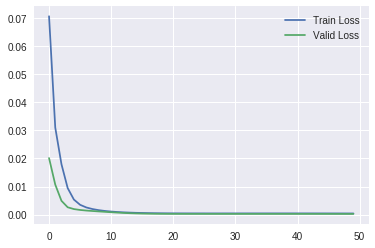

In [101]:
# plot history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.legend()
plt.show()

In [102]:
# make a prediction
yhat_valid = model.predict(x_valid)
y_valid.shape

(70, 1)

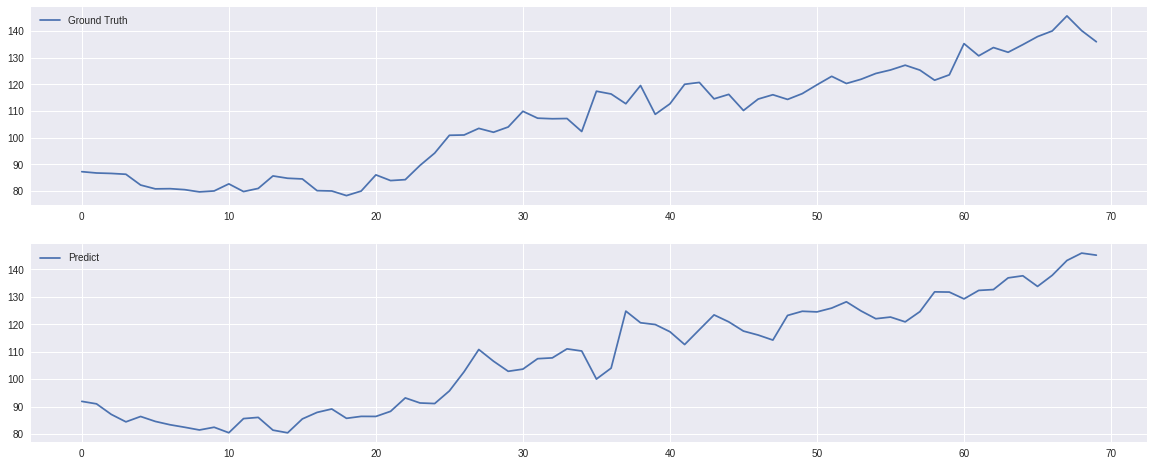

In [104]:
# invert normalization/scaling for prediction on valid set
x_valid_ = x_valid.reshape((n_valid, n_lags*n_variables))
xyhat_valid = x_valid_[:, -n_variables:].copy()
xyhat_valid[:,[index_target]] = yhat_valid
xyhat_valid = scaler.inverse_transform(xyhat_valid)

# invert normalization/scaling for input valid set
x_valid_ = x_valid.reshape((n_valid, n_lags*n_variables))
xy_valid = x_valid_[:, -n_variables:].copy()
xy_valid[:,[index_target]] = y_valid
xy_valid = scaler.inverse_transform(xy_valid)



figsize = (20, 8)
fig = plt.figure(figsize=figsize)
ax = fig.subplots(2, 1)
ax[0].plot(np.arange(0, xy_valid.shape[0]), xy_valid[:, index_target], label="Ground Truth")
ax[0].legend()
ax[1].plot(np.arange(0, xyhat_valid.shape[0]), xyhat_valid[:, index_target], label="Predict")
ax[1].legend()
# ax[1].plot(np.arange(0, y_valid.shape[1]), yhat_valid[0, :], label="Predict")
# ax[1].legend()



In [69]:
x_valid_.shape

(160, 8)

In [88]:
xy_valid.shape

(160, 8)

In [89]:
160/12


13.333333333333334